In [5]:
import numpy as np
import pandas as pd
from sklearn.metrics import zero_one_loss
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import log_loss, roc_curve, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn import datasets
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC 

In [6]:
#Reading the file and splitting our target column
df = pd.read_csv (r'bank-additional.csv', sep = ';', engine= 'python')   

tussen = df[["y"]]
target = tussen.copy()
df.drop(df.columns[len(df.columns)-1], axis=1, inplace=True)

#Encoding all the catergorical variables and deleting them from the old dataframe
categories = ['marital','education','default','housing','loan','contact','month','day_of_week','poutcome']
df_encoded = pd.get_dummies(df['job'], prefix='job', drop_first=False)
df_encoded.insert(0, 'ID', range(0, len(df_encoded)))
del df['job']

for x in categories:
    df_encoded_tussen = pd.get_dummies(df[x], prefix=x, drop_first=True)
    df_encoded_tussen.insert(0, 'ID', range(0, len(df_encoded_tussen)))
    df_encoded = pd.merge(df_encoded, df_encoded_tussen, on = 'ID', how = 'outer')
    del df[x]

df.insert(0, 'ID', range(0, len(df)))
features = pd.merge(df_encoded, df, on = 'ID', how = 'outer')
y = pd.get_dummies(target, drop_first=True)
del features['ID']

Accuracy:  0.887
Confusion Matrix:
[[699  16]
 [ 77  32]]
Classification Report
              precision    recall  f1-score   support

           0       0.90      0.98      0.94       715
           1       0.67      0.29      0.41       109

    accuracy                           0.89       824
   macro avg       0.78      0.64      0.67       824
weighted avg       0.87      0.89      0.87       824



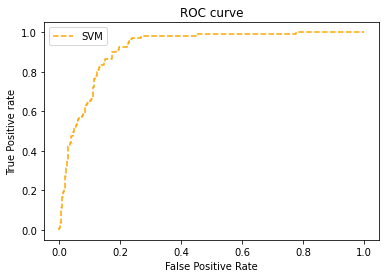

AUC Score: 0.919
Log-Loss: 3.898


In [7]:
train_features, test_features, train_targets, test_targets = train_test_split(features, y.values.ravel(), test_size=0.2,
                                                                                  random_state=23)
#SVM Classifier
classifier = svm.SVC(kernel = 'linear', probability=True)
classifier.fit(train_features, train_targets)

predictions = classifier.predict(test_features)

# Use score method to get accuracy of model
accuracy = metrics.accuracy_score(test_targets, predictions)
print("Accuracy: ", + np.round(accuracy , 3))

print("Confusion Matrix:")
print(confusion_matrix(test_targets, predictions))

print("Classification Report")
print(classification_report(test_targets, predictions))
    
#Beginning the plotting of ROC-curve
pred_prob = classifier.predict_proba(test_features)
fpr, tpr, thresh = roc_curve(test_targets, pred_prob[:,1], pos_label=1)
    
#Plot roc curves
plt.plot(fpr, tpr, linestyle='--',color='orange', label='SVM')

# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();
    
#AUC Score
auc_score = roc_auc_score(test_targets, pred_prob[:,1])
print("AUC Score: " + str(np.round(auc_score , 3)))
    
#Log-loss function
print("Log-Loss: " + str(np.round(log_loss(test_targets, predictions),3)))

In [ ]:
param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly', 'sigmoid']}
grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=2)
grid.fit(train_features,train_targets)
print(grid.best_estimator_)

grid_predictions = grid.predict(test_features)
print(confusion_matrix(test_targets,grid_predictions))
print(classification_report(y_test,grid_predictions))



Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.7s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.7s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.7s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.6s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.7s
